# Machine Learning model for Predicting Linear B-cell Epitopes Using High-Dimensional Protein Features

## Introduction
B-cell epitopes are specific regions on the surface of antigens that are recognized by B-cell receptors and antibodies. Accurate prediction of these linear B-cell epitopes plays a critical role in accelerating vaccine development, diagnostics, and immunotherapy design. However, experimental identification of epitopes is often costly, time-consuming, and limited by biological constraints. Hence, computational methods have emerged as essential tools for screening and prioritizing candidate epitopes.

This coursework aims to tackle the epitope prediction problem using a high-dimensional dataset that was derived from protein sequences, embedded using the ESM-1b model. The dataset contains over 1,200 features per observation and a class label indicating whether or not the protein segment is an epitope.

### Process flow and goals
To solve this problem, I will design a data mining pipeline that will comprise the following four core stages:

**Exploratory Data Analysis (EDA):**

- Understand the data distribution, missing values, outliers, feature types, and class balance.

- Apply visualisation and summarisation techniques to draw insights from high-dimensional data.

**Data Preprocessing and Feature Engineering:**

- Drop non-informative metadata (Info_ columns).

- Apply standard scaling and handle any missing values.

- Reduce dimensionality using unsupervised and/or supervised methods (e.g., PCA, mutual information).

- Address class imbalance using techniques such as SMOTE or cost-sensitive learning.

**Modelling:**

- Train and evaluate multiple classifiers, including Random Forest, XGBoost, and Logistic Regression.

- Use GroupKFold based on Info_cluster to ensure grouped cross-validation and prevent data leakage.

- Select the model with the highest balanced accuracy, a metric well-suited to imbalanced classification.

**Conclusion and Recommendations:**

- Summarize key findings from the EDA, modelling results, and final pipeline performance.

- Offer recommendations for future epitope prediction systems and model refinement.




In [1]:
# Import necessary libraries - initials
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

In [2]:
# Load the dataset
df = pd.read_csv('df.csv', sep=';', engine='python')

## Explore and Understand the data

Exploratory Data Analysis (EDA) will help me to understand the structure, distributions, class balance, and any data quality issues within the dataset, providing insights on the next appropriate step.

### Basic EDA
This will give us basic information about the data such as feature categories, datatypes, missing values, and distribution of outcome class.


Data Shape:
(49606, 1291)

Feature Categories:
Info columns: 9
Feature columns: 1281
Target column: Class

Data types:
float64    1281
object        6
int64         4
Name: count, dtype: int64

Missing values:
feat_esm1b_148     44655
feat_esm1b_1121       88
feat_esm1b_469        88
feat_esm1b_332        88
feat_esm1b_56         88
feat_esm1b_537        88
feat_esm1b_634        88
feat_esm1b_728        88
feat_esm1b_645        88
feat_esm1b_646        88
feat_esm1b_1039       87
feat_esm1b_353        87
feat_esm1b_1157       87
feat_esm1b_86         87
feat_esm1b_667        87
feat_esm1b_691        87
feat_esm1b_1045       87
feat_esm1b_379        87
feat_esm1b_363        87
feat_esm1b_812        87
dtype: int64

Class distribution:
Class
-1    0.983691
 1    0.016309
Name: proportion, dtype: float64


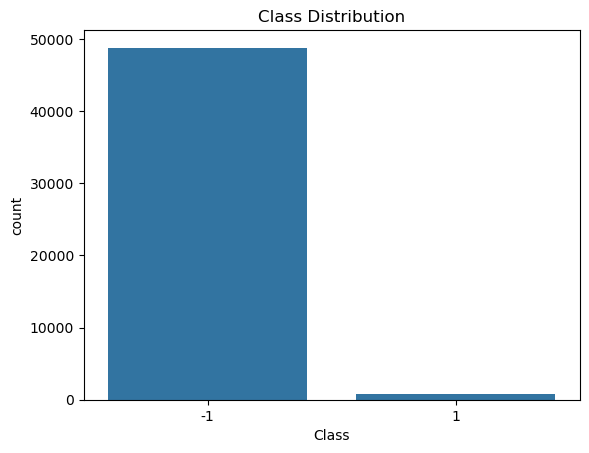

In [3]:
# General overview of the dataset
print("\nData Shape:")
print(df.shape)

# Split column groups to understand the number of features in each category
print("\nFeature Categories:")
info_cols = [col for col in df.columns if col.startswith('Info_')]
feat_cols = [col for col in df.columns if col.startswith('feat_')]
target_col = 'Class'

print(f"Info columns: {len(info_cols)}")
print(f"Feature columns: {len(feat_cols)}")
print(f"Target column: {target_col}")

# Understanding the basic structure of data - data types andd mssing values
print("\nData types:")
print(df.dtypes.value_counts())

print("\nMissing values:")
print(df.isnull().sum().sort_values(ascending=False).head(20))

# Exploring the class distribution
print("\nClass distribution:")
print(df[target_col].value_counts(normalize=True))

sns.countplot(data=df, x=target_col)
plt.title("Class Distribution")
plt.show()

Key findings 
> - The dataset comprises of 49,606 observations and 1,291 features - out of which 99.2% of the columns are features, and 0.69% are Info columns - indicating highly dimensional feature space. 
> - The feature - `feat_esm1b_148` has the highest number of missing values - up to 90% of the entire data, while the rest of the features has at most less than 0.2% of the data missing.
> - The class variable is highly imbalanced, with a majority class `-1` representing 98.4% of the data. Predicting the minority class `1` of only 1.6% of the entire data will be challenging without addressing it by utilizing techniques such as `Cost-sensitive learning`, `SMOTE / ADASYN` 

To handle the missing data, i'll drop the feature - `feat_esm1b_148`, and and consider imputing the rest with `Median`

### Validate the imputation choice
I'll perform more EDA to help me decide on the method of imputation - either `Mean` or `Median`

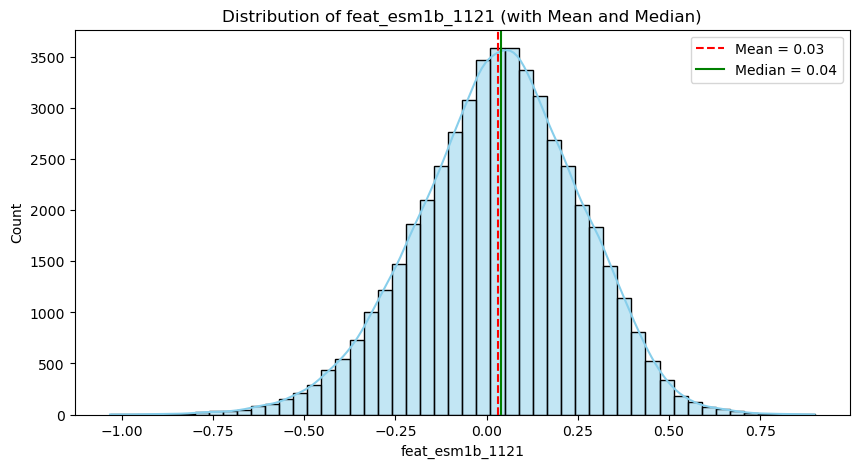

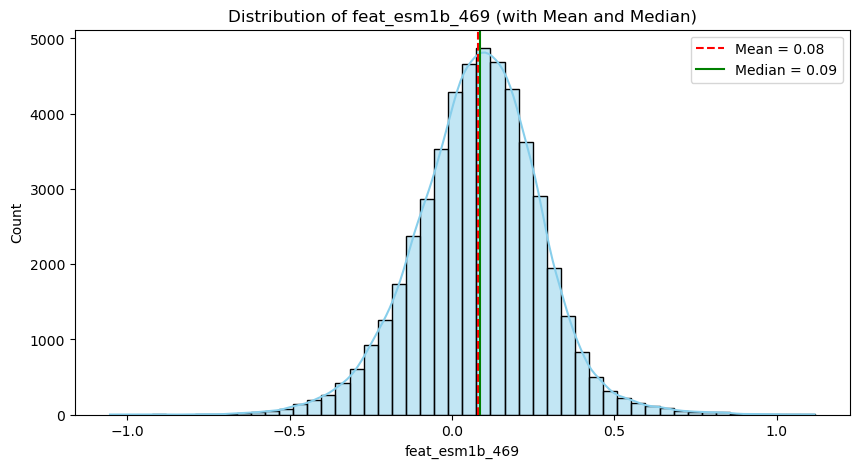

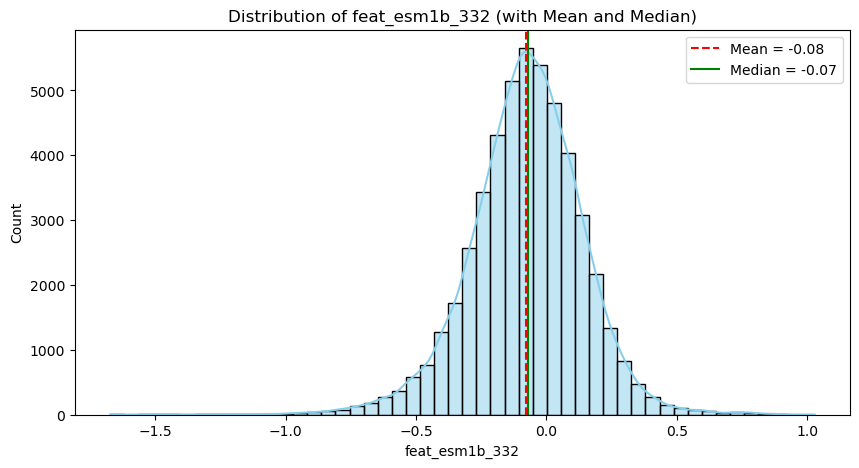

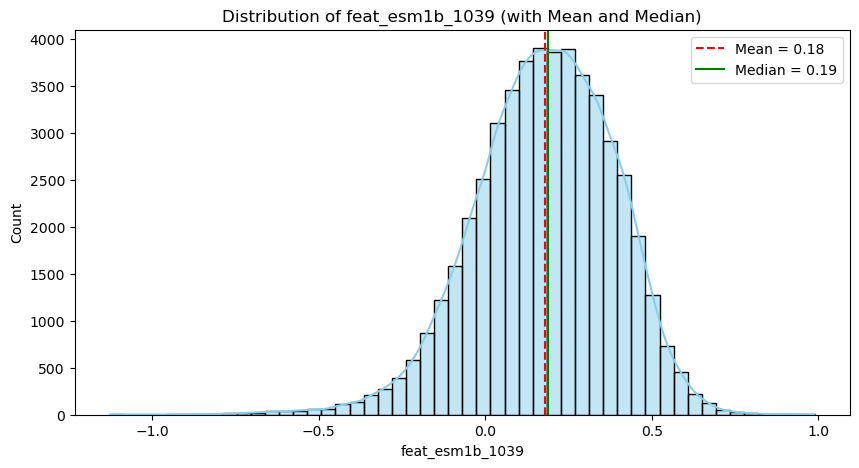

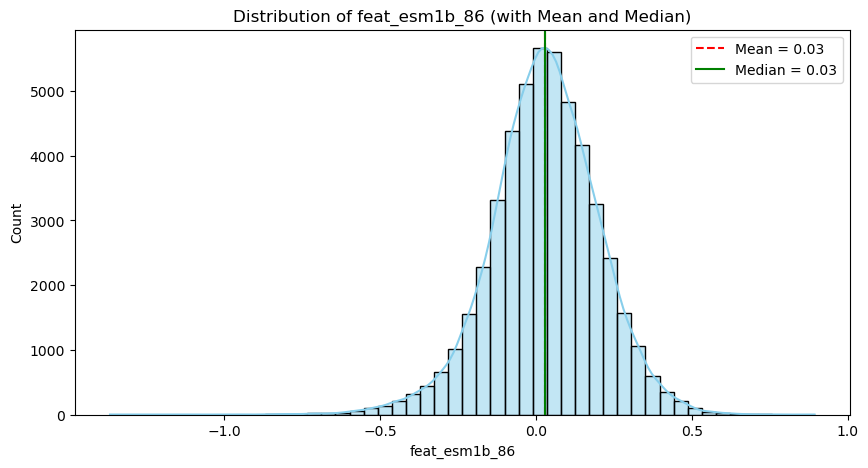

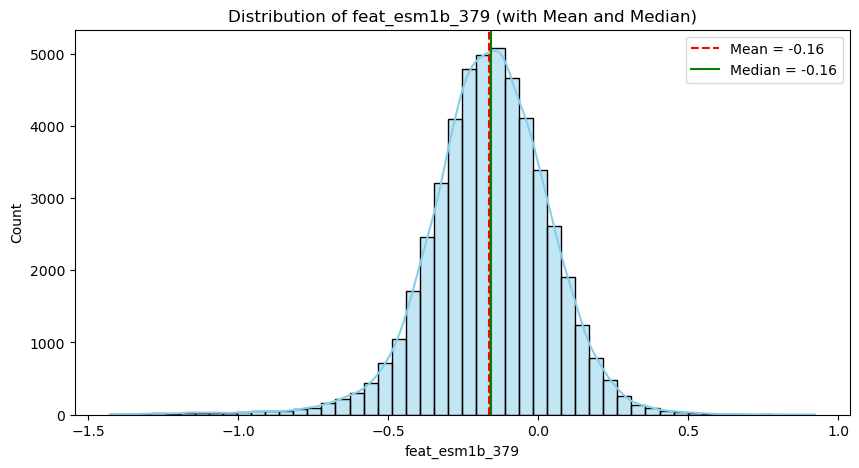


Skewness, Mean, and Median of Features with Missing Values:
feat_esm1b_1121: Skewness = -0.22, Mean = 0.03, Median = 0.04
feat_esm1b_469: Skewness = -0.07, Mean = 0.08, Median = 0.09
feat_esm1b_332: Skewness = -0.29, Mean = -0.08, Median = -0.07
feat_esm1b_1039: Skewness = -0.43, Mean = 0.18, Median = 0.19
feat_esm1b_86: Skewness = -0.28, Mean = 0.03, Median = 0.03
feat_esm1b_379: Skewness = -0.54, Mean = -0.16, Median = -0.16


In [4]:
from scipy.stats import skew

# Select a few features with missing values for visualization
# Here, we will visualize the distributions of features with significant missing values
missing_features = ['feat_esm1b_1121', 'feat_esm1b_469', 'feat_esm1b_332', 'feat_esm1b_1039', 'feat_esm1b_86', 'feat_esm1b_379']

# Visualize the feature's distributions
for feat in missing_features:
    plt.figure(figsize=(10, 5))
    
    sns.histplot(df[feat], kde=True, bins=50, color='skyblue')
    plt.axvline(df[feat].mean(), color='red', linestyle='--', label=f"Mean = {df[feat].mean():.2f}")
    plt.axvline(df[feat].median(), color='green', linestyle='-', label=f"Median = {df[feat].median():.2f}")
    plt.title(f'Distribution of {feat} (with Mean and Median)')
    plt.legend()
    plt.show()

# Quantify the Skewness of each feature
print("\nSkewness, Mean, and Median of Features with Missing Values:")
for feat in missing_features:
    skew_val = skew(df[feat].dropna())
    mean_val = df[feat].mean()
    median_val = df[feat].median()
    
    print(f"{feat}: Skewness = {skew_val:.2f}, Mean = {mean_val:.2f}, Median = {median_val:.2f}")


This result reveals that the features show: 
> - Mild to moderate negative skew - though subtle, the mean can be pulled by the tail, while the median will remains stable in skewed distributions - mean is very sensitive to `outliers`
> - No severe skewness `|skewness| > 1`, hence, both `Mean` and `Median` could be acceptable for imputation
> - The differences between mean and median are small, which implies few or no extreme outliers in the features with missing value

Let's further visualize and compare effect of imputation with either `Mean` or `Median`

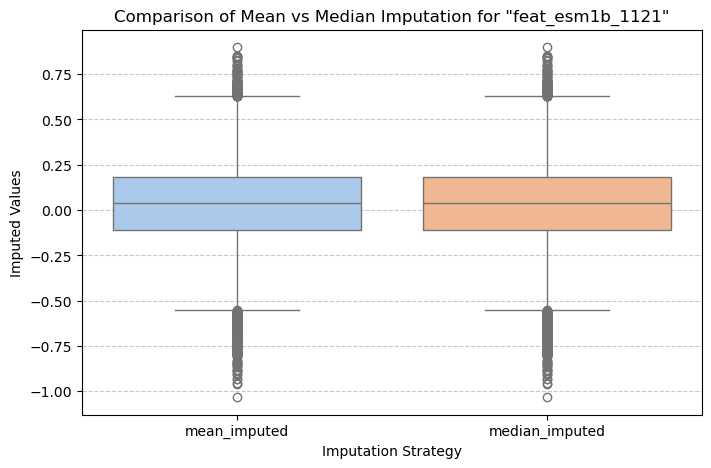

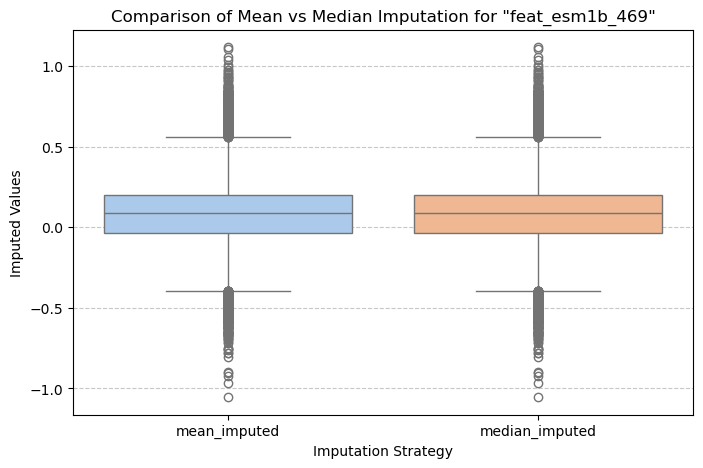

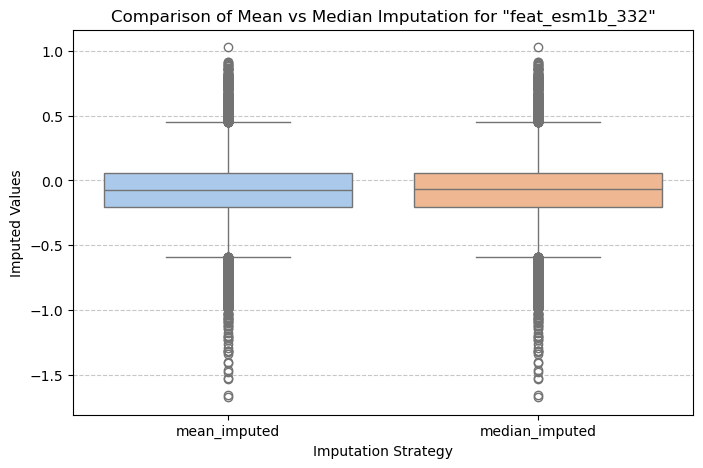

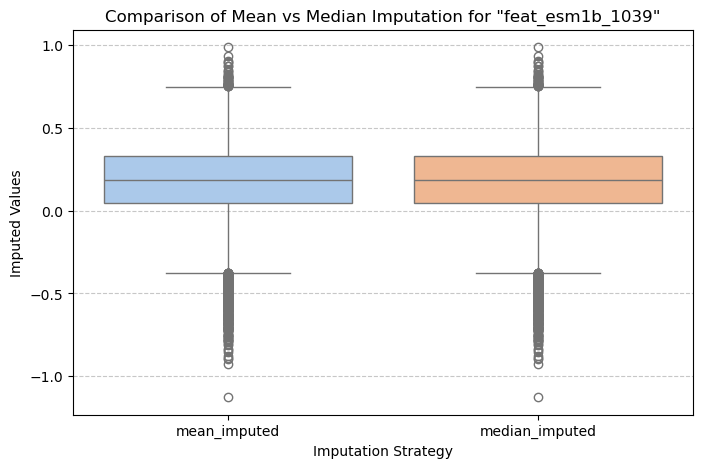

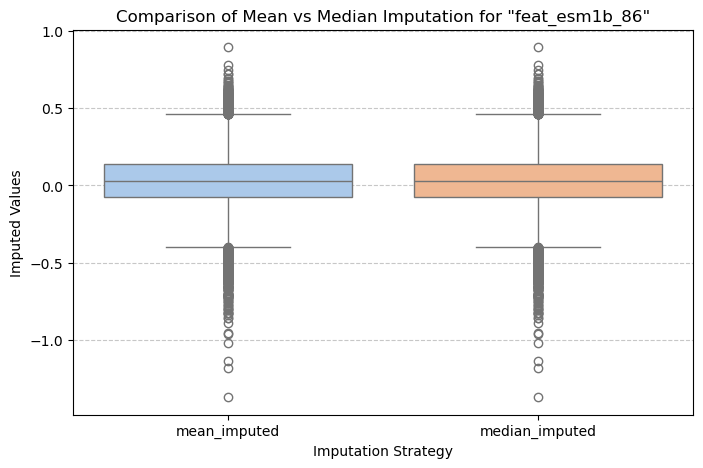

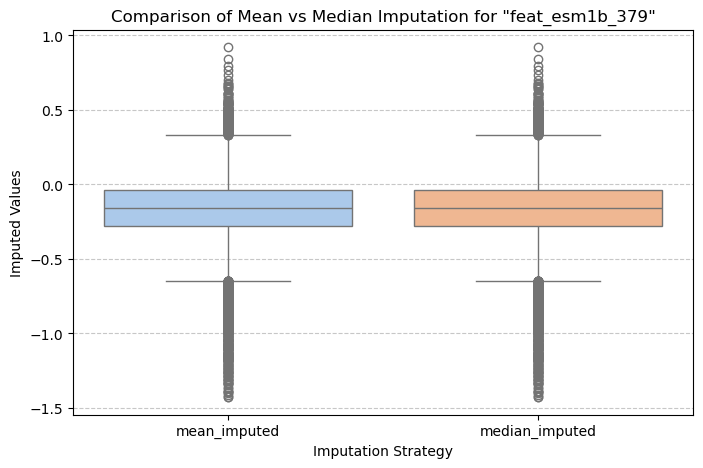

In [5]:
from sklearn.impute import SimpleImputer

for feat in missing_features:
    # Create a copy
    temp_df = df[[feat]].copy()

    # Impute using mean and median
    mean_imputer = SimpleImputer(strategy='mean')
    median_imputer = SimpleImputer(strategy='median')

    # Perform imputation and flatten the output - fit_transform returns a 2D array
    temp_df['mean_imputed'] = mean_imputer.fit_transform(temp_df[[feat]]).ravel()
    temp_df['median_imputed'] = median_imputer.fit_transform(temp_df[[feat]]).ravel()

    # Melt the DataFrame for seaborn boxplot
    melted_df = temp_df.melt(value_vars=['mean_imputed', 'median_imputed'], 
                            var_name='Imputation Strategy', 
                            value_name='Value')

    # Plot boxplots
    plt.figure(figsize=(8, 5))
    sns.boxplot(data=melted_df, x='Imputation Strategy', y='Value', palette='pastel', hue='Imputation Strategy', legend=False)
    plt.title(f'Comparison of Mean vs Median Imputation for "{feat}"')
    plt.ylabel('Imputed Values')
    plt.grid(axis='y', linestyle='--', alpha=0.7)
    plt.show()


Though the visuals look identical, since the skewness is negative, and `Mean` is sensitive to outliers, even if subtle.
> `Median` imputation will be adopted.

### Data Cleaning

In [6]:
# Drop 'feat_esm1b_148' due to excessive missing values
df = df.drop(columns=['feat_esm1b_148'])

# Remove 'feat_esm1b_148' from feat_cols
feat_cols = [col for col in feat_cols if col != 'feat_esm1b_148']

# Define feature matrix X and target y
X = df[feat_cols]
y = df['Class']

# Impute missing values with median
imputer = SimpleImputer(strategy='median')
X_imputed = pd.DataFrame(imputer.fit_transform(X), columns=X.columns)

# Check shape of data after imputation and confirm no missing values remain
print(f"X shape after imputation: {X_imputed.shape}")
print(f"Missing values remaining: {X_imputed.isnull().sum().sum()}")


X shape after imputation: (49606, 1280)
Missing values remaining: 0


#### Feature variance analysis
Feature variance analysis is necessary for dimensionality reduction and identification of uninformative predictors, it is basically a systematic assessment of feature variance to identify and remove low-variance (i.e. uninformative) features, thereby improving model efficiency and reducing noise in high-dimensional data

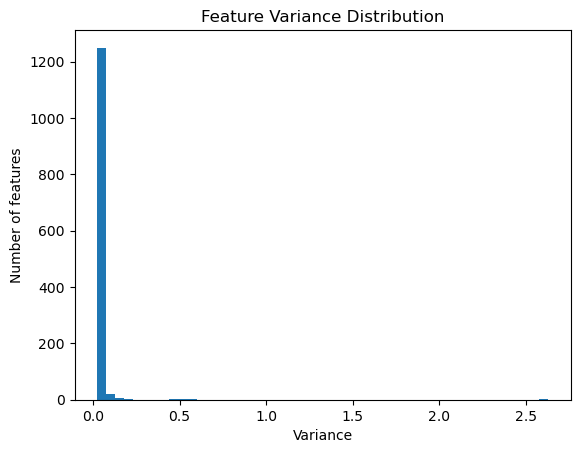

In [7]:
# Visualizing the Variance Threshold for feature selection
variances = X_imputed.var()
plt.hist(variances, bins=50)
plt.xlabel('Variance')
plt.ylabel('Number of features')
plt.title('Feature Variance Distribution')
plt.show()

In [8]:
# Numerically identifying the number of low-variance features
from sklearn.feature_selection import VarianceThreshold

for thresh in [0.0, 0.01, 0.02, 0.03, 0.04, 0.05, 0.1]:
    selector = VarianceThreshold(threshold=thresh)
    selector.fit(X_imputed)
    num_removed = (~selector.get_support()).sum()
    print(f"Threshold {thresh}: {num_removed} features removed")

Threshold 0.0: 0 features removed
Threshold 0.01: 0 features removed
Threshold 0.02: 0 features removed
Threshold 0.03: 50 features removed
Threshold 0.04: 588 features removed
Threshold 0.05: 1016 features removed
Threshold 0.1: 1268 features removed


This result gives us some ideas on how to eliminate some features from our feature space - as features with variance less than 0.05 are likely to be uninformative for machine learning models. Low-variance features do not change much across samples, however, we would check the performance model after removing low-variance features to determine if such features would be retained or completely removed.

In [9]:
# Extracting low-variance features at a threshold of 0.05
selector = VarianceThreshold(threshold=0.05)  # Tune threshold if needed
selector.fit(X_imputed)
low_var_features = X_imputed.columns[~selector.get_support()]
print(f"Low-variance features: {len(low_var_features)}")

Low-variance features: 1016


These `low_var_features` would be dropped after confirming that our model performs better without them.

#### Identify the top 20 features by importance or variance

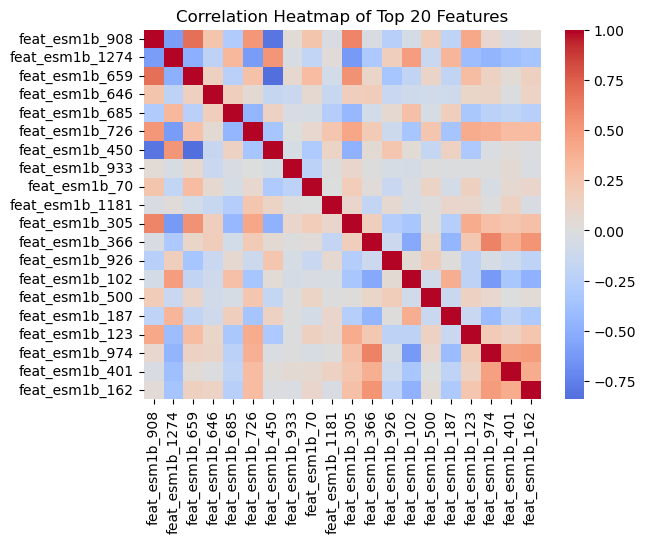

In [10]:
top_var_features = X_imputed.var().sort_values(ascending=False).head(20).index
sns.heatmap(X_imputed[top_var_features].corr(), cmap='coolwarm', center=0)
plt.title("Correlation Heatmap of Top 20 Features")
plt.show()


This heatmap reveals that `feat_esm1b_450` is highly correlated with `feat_esm1b_908` and `feat_esm1b_659`, indicating the presence of multicolinearity between the features.

#### Verifying suspected features

In [11]:
corr_matrix = X_imputed[top_var_features].corr().abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Find feature pairs with correlation > 0.8
high_corr_pairs = [(col, row, upper.loc[row, col]) 
                   for col in upper.columns 
                   for row in upper.index 
                   if upper.loc[row, col] > 0.8]

print("Highly correlated feature pairs (|corr| > 0.8):")
for pair in high_corr_pairs:
    print(pair)

Highly correlated feature pairs (|corr| > 0.8):
('feat_esm1b_450', 'feat_esm1b_908', 0.8005877884643648)
('feat_esm1b_450', 'feat_esm1b_659', 0.841468896719816)


These features are certainly highly correlated with `|corr| >= 0.8`, confirming our concern for multicolinearity. Hence, `feat_esm1b_450` will be dropped 

#### Perform PCA to visualize the distribution of the classes
This will help us to visualize whether the minority class is deeply embedded or separable. 

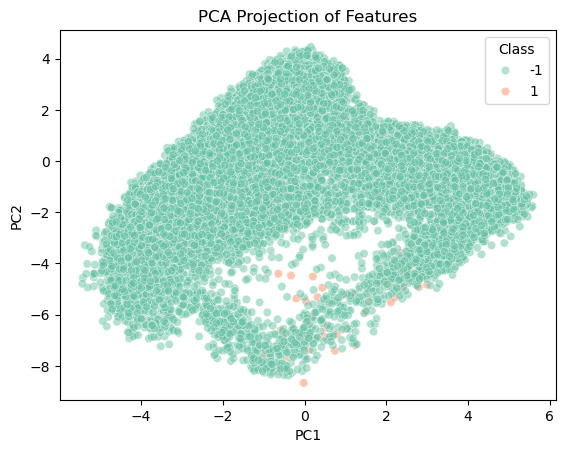

In [12]:
from sklearn.decomposition import PCA

pca = PCA(n_components=2)
X_pca = pca.fit_transform(X_imputed)

pca_df = pd.DataFrame(X_pca, columns=['PC1', 'PC2'])
pca_df['Class'] = y.values

sns.scatterplot(data=pca_df, x='PC1', y='PC2', hue='Class', palette='Set2', alpha=0.5)
plt.title('PCA Projection of Features')
plt.show()


> - This PCA chart suggests that the minority class represented as 1, shown in light orange is deeply embedded within the majority class represented as -1 and shown in green. 
> - The minority points are scattered and overlapped by the majority, indicating poor separability in the first two principal components. 
> - This suggests that distinguishing the minority class will be mostly challenging for our classification task. Hence, the need to drastically reduce the features for meaningful modelling

#### Rank the features by importance
This is to identify informative features for to aid our feature reduction

In [13]:
from sklearn.feature_selection import mutual_info_classif

mi_scores = mutual_info_classif(X_imputed, y)
mi_series = pd.Series(mi_scores, index=X_imputed.columns).sort_values(ascending=False)
print("Top 10 Features by Mutual Information:\n", mi_series.head(10))


Top 10 Features by Mutual Information:
 feat_esm1b_1119    0.012159
feat_esm1b_733     0.011353
feat_esm1b_789     0.011270
feat_esm1b_450     0.011228
feat_esm1b_1134    0.010649
feat_esm1b_202     0.009330
feat_esm1b_1125    0.008578
feat_esm1b_1237    0.008551
feat_esm1b_292     0.008389
feat_esm1b_16      0.008121
dtype: float64


This result shows that `feat_esm1b_1119` is the most informative feature, with a `Mutual Information` score of `0.012159`,

In [14]:
mi_series.tail(200)

feat_esm1b_1100    0.000287
feat_esm1b_39      0.000276
feat_esm1b_223     0.000265
feat_esm1b_799     0.000264
feat_esm1b_125     0.000257
                     ...   
feat_esm1b_1129    0.000000
feat_esm1b_1130    0.000000
feat_esm1b_545     0.000000
feat_esm1b_48      0.000000
feat_esm1b_796     0.000000
Length: 200, dtype: float64

The bottom 200 features with the lowerest mutual information are mostly close to zero, indicating that they would not contribute meaningfully to the model.

#### Ploting the Mutual Information
We would plot the mutual information scores of all features to help us visualize these score - and aid us in deciding how to eliminate some uninformative features

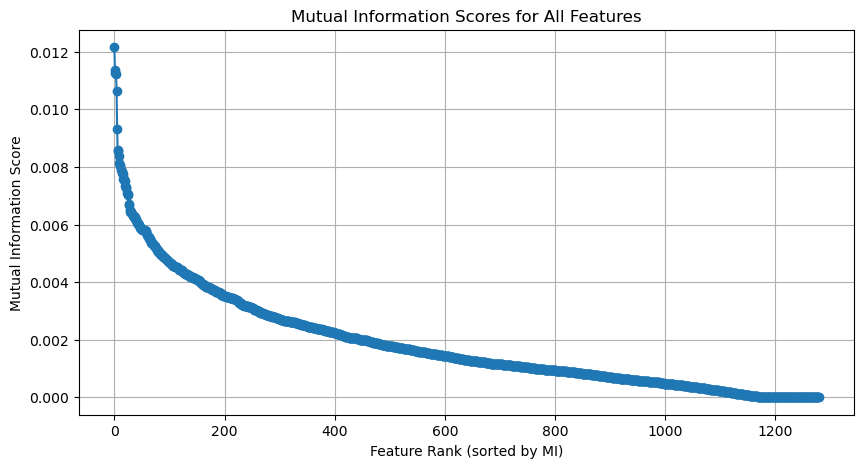

In [15]:
import matplotlib.pyplot as plt

# Plot sorted mutual information scores
plt.figure(figsize=(10, 5))
plt.plot(range(len(mi_series)), mi_series.values, marker='o')
plt.xlabel('Feature Rank (sorted by MI)')
plt.ylabel('Mutual Information Score')
plt.title('Mutual Information Scores for All Features')
plt.grid(True)
plt.show()

Based on this mutual information plot, I will select features by identifying the `elbow` point where the mutual information scores sharply decrease and the curve begins to flatten. This point indicates a transition from highly informative features to those that contribute little additional information. By choosing features up to this elbow (approximately the top 20–30 features), it ensures that only the most relevant predictors are retained for modeling, thereby reducing dimensionality and potential noise while preserving the majority of the predictive power in the dataset. However, the features will be adjust as needed based on model performance.



####  Distribution of Selected Top Features
Let's manually inspect the top 10 features for class-based separation

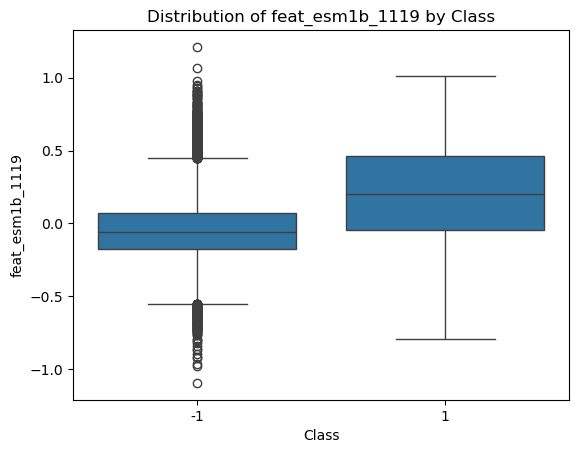

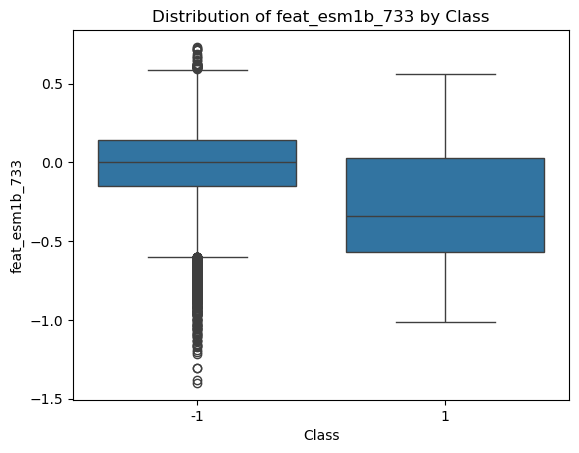

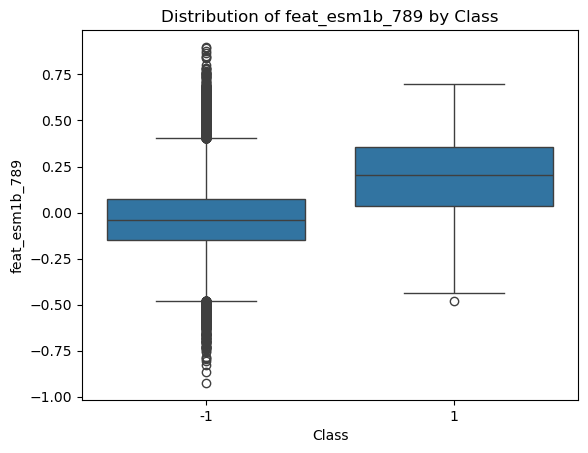

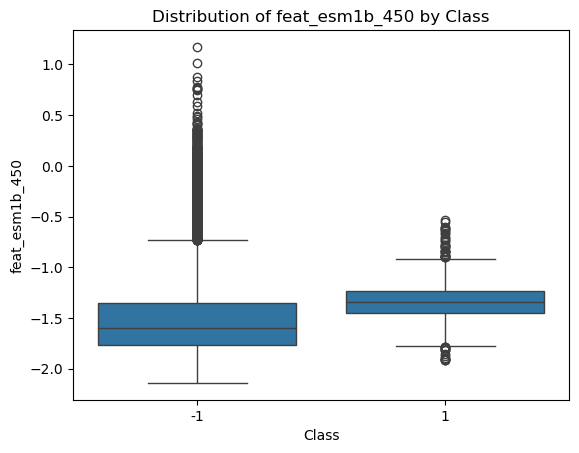

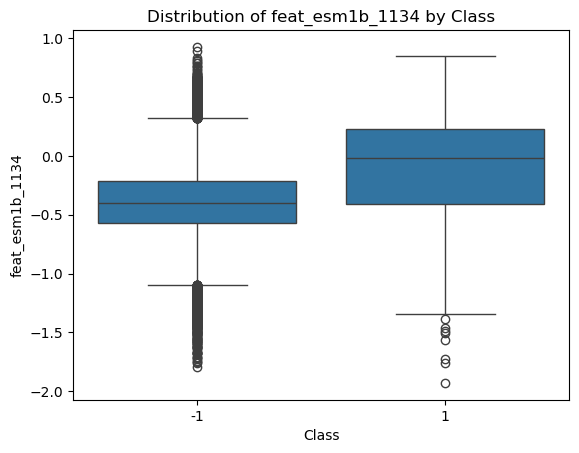

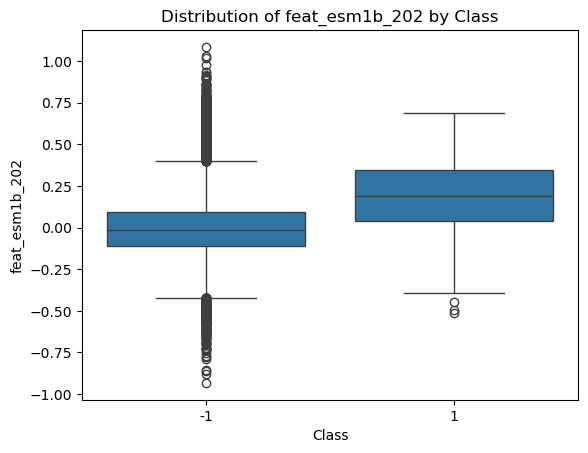

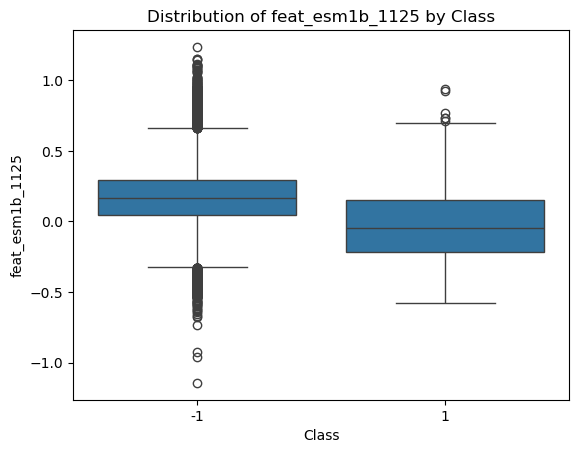

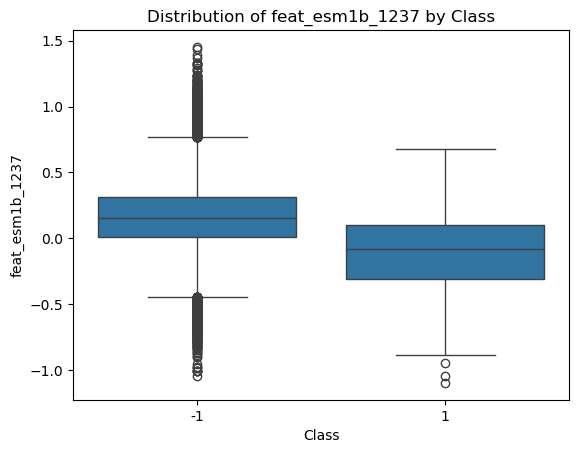

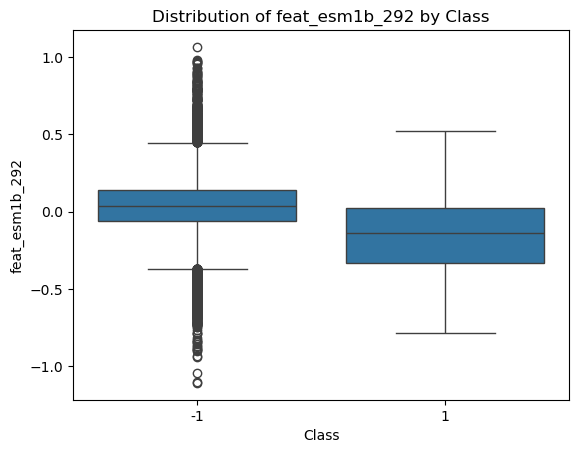

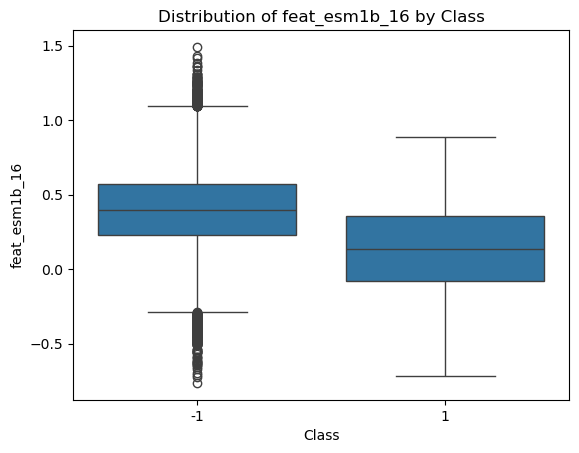

In [16]:
top_feats = mi_series.head(10).index
for col in top_feats:
    sns.boxplot(x=y, y=X_imputed[col])
    plt.title(f"Distribution of {col} by Class")
    plt.show()


This results reveal that there is differences in `medians` between the two classes, across the ten feature, which reflects a shift in central tendency, suggesting that the features may help distinguish between the classes. A signal of the predictive power of the features

Through these EDAs, we now understand that basically the most informative features fall within the range of 20 to 30 features. Let's use three different feature selection methods to select our features by applying these techniques to identify and retain only the most relevant features.

We will implement the `Filter` based feature selection methods - `Variance Threshold` and `Correlation based filtering`, the Wrapper method - `Recursive Feature Elimination`, the `Embedded` method - `L1-Regularized Logistic Regression`

#### Feature Selection

**Variance Threshold**
During the EDA, we identified `0.05` as a reasonable variance threshold to start with for our dimentionality reduction.

In [34]:
from sklearn.feature_selection import VarianceThreshold

# Remove features with variance < 0.05
for threshold in np.arange(0.01, 0.10, 0.01):
    print(f"Threshold: {threshold:.2f}", end=" - ")
    selector = VarianceThreshold(threshold=threshold)
    X_var = selector.fit_transform(X_imputed)
    print(f"Features Reduced from {X_imputed.shape[1]} to {X_var.shape[1]} features")


Threshold: 0.01 - Features Reduced from 1280 to 1280 features
Threshold: 0.02 - Features Reduced from 1280 to 1280 features
Threshold: 0.03 - Features Reduced from 1280 to 1230 features
Threshold: 0.04 - Features Reduced from 1280 to 692 features
Threshold: 0.05 - Features Reduced from 1280 to 264 features
Threshold: 0.06 - Features Reduced from 1280 to 104 features
Threshold: 0.07 - Features Reduced from 1280 to 52 features
Threshold: 0.08 - Features Reduced from 1280 to 26 features
Threshold: 0.09 - Features Reduced from 1280 to 15 features


For our modelling based on this result, we would select three representative thresholds and evaluate their effect on the model - `0.03`, `0.05`, and `0.07`

**Correlation based filter**
From previous EDA, we discovered highly correlated features at `|cor| > 0.8`, we would use this value to drop highly correlated features.

In [36]:
# Correlation matrix
corr_matrix = pd.DataFrame(X_imputed).corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.8
to_drop = [column for column in upper.columns if any(upper[column] > 0.8)]
X_corr = pd.DataFrame(X_imputed).drop(columns=to_drop)
print(f"Removed {len(to_drop)} highly correlated features")


Removed 2 highly correlated features


**Recursive Feature Elimination (RFE)**


In [ ]:
from sklearn.feature_selection import RFE
from sklearn.ensemble import RandomForestClassifier

rfe_selector = RFE(RandomForestClassifier(), n_features_to_select=50, step=10)
X_rfe = rfe_selector.fit_transform(X_imputed, y)
print(f"Selected top 50 features using RFE")


KeyboardInterrupt: 

In [37]:
from sklearn.linear_model import LogisticRegression
from sklearn.feature_selection import SelectFromModel

log_model = LogisticRegression(penalty='l1', solver='liblinear', max_iter=500)
embed_selector = SelectFromModel(log_model)
X_embed = embed_selector.fit_transform(X_imputed, y)
print(f"Embedded method retained {X_embed.shape[1]} features")


Embedded method retained 704 features
